<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Regression in PyTorch

Let's use the PyTorch **automatic differentiation** library to solve the regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Machine Learning Foundations: Linear Algebra II: Matrix Operations* notebook](http://127.0.0.1:8888/notebooks/work/notebooks/2-linear-algebra-ii.ipynb).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch

As in *Linear Algebra II*, in machine learning the convention is that each row represents an instance: 

In [0]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7.]).reshape(-1, 1)

In [3]:
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.]])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [0]:
# y = -0.5*x + 2 + np.random.normal(scale=0.2, size=8).reshape(-1,1)
# For reproducibility, here's a fixed example of y values from running the line above: 
y = np.array([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]).reshape(-1, 1)

In [5]:
y

array([[ 1.86],
       [ 1.31],
       [ 0.62],
       [ 0.33],
       [ 0.09],
       [-0.67],
       [-1.23],
       [-1.37]])

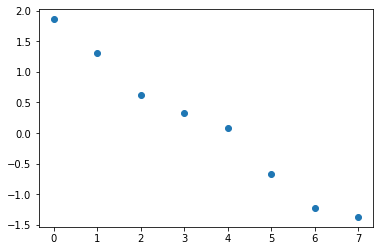

In [6]:
fig, ax = plt.subplots()
_ = ax.scatter(x, y)

`nn.Linear` applies the transformation $y = xW^T + b$ where $W$ is a matrix of weights and $b$ is a vector of biases. In this example, there is only a single weight and a single bias ($y$-intercept) value because of how we've constrained the number of inputs ($x$) and outputs ($y$) to `linear` both to `1`:

In [0]:
class LinearRegression(torch.nn.Module):
    
    # Superclassing of new Module is standard in PyTorch
    def __init__(self): 
        super(LinearRegression, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    
    # Define the forward pass: 
    def forward(self, my_x):
        my_y = self.linear(my_x)
        return my_y

In [0]:
model = LinearRegression()

Our model will learn to approximate $m$, the slope between $x$ and $y$: 

In [9]:
m = model.linear.weight 
m

Parameter containing:
tensor([[0.3684]], requires_grad=True)

In [10]:
## For strong example, can optionally fix m to 0.9: 
# model.linear.weight = torch.nn.Parameter(torch.tensor([[0.9]]))
# m = model.linear.weight 
# m

Parameter containing:
tensor([[0.9000]], requires_grad=True)

...same goes for the $y$-intercept $b$: 

In [11]:
b = model.linear.bias 
b

Parameter containing:
tensor([0.6325], requires_grad=True)

In [12]:
## Likewise, bias could be fixed to 0.1: 
# model.linear.bias = torch.nn.Parameter(torch.tensor([0.1]))
# b = model.linear.bias
# b

Parameter containing:
tensor([0.1000], requires_grad=True)

Prior to training, the model has a random slope $m$ and random intercept $b$: 

In [0]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = my_b, my_b + my_m*(x_max-x_min)

    ax.plot([x_min, x_max], [y_min, y_max])
    _ = ax.set_xlim([x_min, x_max])

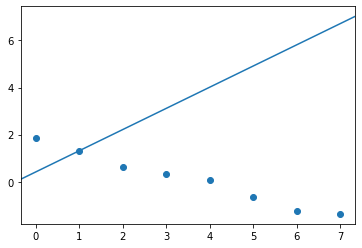

In [14]:
regression_plot(x, y, m, b)

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. MSE cost $C$ is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [0]:
def mse_cost(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [0]:
x_pt = torch.from_numpy(x).float()

In [18]:
x_pt

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.]])

In [19]:
x_pt.requires_grad_()

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.]], requires_grad=True)

Forward pass:

In [0]:
yhat = model(x_pt) 

In [21]:
yhat

tensor([[0.1000],
        [1.0000],
        [1.9000],
        [2.8000],
        [3.7000],
        [4.6000],
        [5.5000],
        [6.4000]], grad_fn=<AddmmBackward>)

In [0]:
y_pt = torch.from_numpy(y).float()

In [23]:
cost = mse_cost(yhat, y_pt)
cost

tensor(19.6755, grad_fn=<DivBackward0>)

Chain rule to differentiate with respect to model parameters:

In [0]:
cost.backward() 

In [25]:
model.linear.weight.grad

tensor([[36.3050]])

In [26]:
model.linear.bias.grad

tensor([6.2650])

Use differentiation results to adjust model parameters in direction of lower cost: 

In [0]:
optimizer.step()

In [28]:
yhat = model(x_pt)
cost = mse_cost(yhat, y_pt)
cost

tensor(13.5536, grad_fn=<DivBackward0>)

After a round of training, the model fits better, although it isn't always easy to tell by eye: 

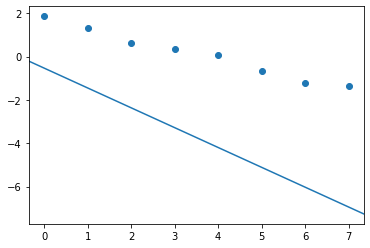

In [29]:
regression_plot(x, y, model.linear.weight, model.linear.bias)

In [30]:
epochs = 100
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = model(x_pt) 
    cost = mse_cost(yhat, y_pt) 
    
    cost.backward() 
    optimizer.step()
    
    print('Epoch {}, cost {}, grad of m {}, grad of b {}'.format(epoch, '%.3g' % cost.item(), '%.3g' % model.linear.weight.grad.item(), '%.3g' % model.linear.bias.grad.item()))

Epoch 0, cost 13.6, grad of m -29.4, grad of b -7.07
Epoch 1, cost 9.41, grad of m 24.5, grad of b 3.94
Epoch 2, cost 6.6, grad of m -19.8, grad of b -5.05
Epoch 3, cost 4.69, grad of m 16.6, grad of b 2.38
Epoch 4, cost 3.39, grad of m -13.3, grad of b -3.67
Epoch 5, cost 2.5, grad of m 11.2, grad of b 1.35
Epoch 6, cost 1.89, grad of m -8.91, grad of b -2.72
Epoch 7, cost 1.47, grad of m 7.63, grad of b 0.668
Epoch 8, cost 1.17, grad of m -5.96, grad of b -2.07
Epoch 9, cost 0.961, grad of m 5.19, grad of b 0.222
Epoch 10, cost 0.81, grad of m -3.97, grad of b -1.62
Epoch 11, cost 0.7, grad of m 3.55, grad of b -0.0656
Epoch 12, cost 0.617, grad of m -2.64, grad of b -1.3
Epoch 13, cost 0.553, grad of m 2.43, grad of b -0.247
Epoch 14, cost 0.502, grad of m -1.74, grad of b -1.07
Epoch 15, cost 0.461, grad of m 1.68, grad of b -0.358
Epoch 16, cost 0.427, grad of m -1.13, grad of b -0.91
Epoch 17, cost 0.398, grad of m 1.17, grad of b -0.422
Epoch 18, cost 0.372, grad of m -0.729, gr

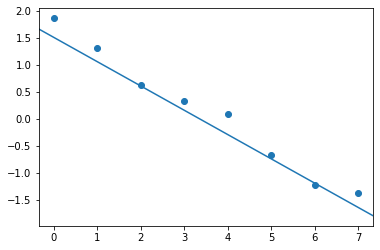

In [31]:
regression_plot(x, y, model.linear.weight, model.linear.bias)